In [36]:
## IMPORTS

# External modules
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import time
# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_absolute_percentage_error

# ignorando warnings
import warnings
warnings.filterwarnings('ignore')

# Project modules
import filter

In [96]:
## FUNCTIONS


## DATAFRAME CREATION
def get_artworks_df():
    artworks = pd.read_csv('../temporary-files/saatchi_artworks_info.csv')
    artworks.rename(columns=lambda x: x.title(), inplace=True)
    artworks.rename(columns={'Price': 'Price (US$)', 'Size': 'Size (in²)'}, inplace=True)
    artworks = calculate_area_and_price_per_area(artworks)

    artworks.dropna(subset=['Price (US$)', 'Size (in²)'])
    
    for column_name in ['Styles', 'Mediums', 'Subjects', 'Materials']:
        artworks[column_name] = artworks[column_name].apply(lambda x: [str(value.strip()) for value in x.split(',')])

    # Filter out non 'one-of-a-kind' artworks
    artworks = artworks[artworks['Original'] == 'One-of-a-kind Artwork']

    # column Artist as single-item list
    artworks['Artist'] = artworks['Artist'].apply(lambda x: [x])
    
    # Remove outliers (artworks with Price (US$/in²) in the 5% and 95% percentiles)
    artworks = artworks[artworks['Price (US$/in²)'] > artworks['Price (US$/in²)'].quantile(0.05)]
    artworks = artworks[artworks['Price (US$/in²)'] < artworks['Price (US$/in²)'].quantile(0.95)]
    return artworks


def calculate_area_and_price_per_area(dataframe):
    # Iterate over the "Size" column
    df = dataframe.copy()
    for i, size in enumerate(dataframe['Size (in²)']):
        # Extract the dimensions using regular expression
        dimensions = re.findall(r'\d+(?:\.\d+)?', size)
        if len(dimensions) >= 2:
            # Extract the width and height dimensions
            try:
                width = float(dimensions[0])
                height = float(dimensions[1])
                total_area = width * height
                df.at[i, 'Size (in²)'] = total_area
            except:
                df.at[i, 'Size (in²)'] = 'NaN'
    df['Price (US$/in²)'] = df['Price (US$)'] / df['Size (in²)']

    return df


def get_occurrence_count_on_col_dict(values):
    # Get all unique values from the column
    occurrences_counts_dict = dict(Counter(values))
    return occurrences_counts_dict


def create_segments_dataframe(segments_dfs):
    all_segments_df = pd.DataFrame(index=segments_dfs.keys(),
                                   columns=['Mean Price (US$/in²)', 'Median Price (US$/in²)',
                                            'Standard Dev Price (US$/in²)', 'Variance (US$/in²)' 'Count (#)'])
    for key, value in segments_dfs.items():
        # all_segments_df.loc[key, 'Mean Price (US$)'] = value['Price (US$)'].mean().round(0)
        # all_segments_df.loc[key, 'Median Price (US$)'] = value['Price (US$)'].median().round(0)
        # all_segments_df.loc[key, 'Standard Dev Price (US$)'] = value['Price (US$)'].std().round(0)
        # all_segments_df.loc[key, 'Variance (US$)'] = value['Price (US$)'].var().round(0)

        all_segments_df.loc[key, 'Mean Price (US$/in²)'] = value['Price (US$/in²)'].mean().round(2)
        all_segments_df.loc[key, 'Median Price (US$/in²)'] = value['Price (US$/in²)'].median().round(2)
        all_segments_df.loc[key, 'Standard Dev Price (US$/in²)'] = value['Price (US$/in²)'].std().round(2)
        all_segments_df.loc[key, 'Variance (US$/in²)'] = value['Price (US$/in²)'].var().round(2)

        all_segments_df.loc[key, 'Count (#)'] = len(value)
    all_segments_df.sort_values(by='Mean Price (US$/in²)', ascending=False, inplace=True)
    return all_segments_df


# def group_by_segments(artworks_data, column_name, column, occurrences_threshold):

#     segments_dfs = get_dfs_for_segments(filtered_artworks_data, column_name, occurrence_count_on_col_dict, occurrences_threshold)

#     create_segments_dataframe(segments_dfs)
    
#     # New dataframe for each segment
#     segments_dfs = {}
#     for key, value in occurrence_count_on_col_dict.items():
#         if value > occurrences_threshold:
#             segments_dfs[key] = dataframe[dataframe[column_name].apply(lambda x: key in x)]
#     return segments_dfs



def analyse_by_column(dataframe, column_name, threshold):
    artworks_count_by_segment = dataframe[column_name].value_counts()
    artworks_count_pct_by_segment = artworks_count_by_segment / dataframe[column_name].value_counts().sum()
    selection = artworks_count_by_segment[artworks_count_by_segment > threshold].index
    dataframe = dataframe[dataframe[column_name].isin(selection)]
    return dataframe

def compare_segments(dataframe, segments_to_compare, x_column_name, y_column_name):
    for segment in segments_to_compare:

        if segment == 'All':
            segment_df = dataframe
        else:
            segment_df = segments_dfs[segment]

        x = segment_df[[x_column_name]]
        y = segment_df[y_column_name]
        print('stats:', get_stats(segment_df, x, y))
        get_all_models(x, y)

        xlim = (0, 10000)
        ylim = (0, 40000)


def get_segments_for_column(column):
    segments = [value for sublist in column for value in sublist]
    return segments


def segment_and_clean_data(artworks_data, column_name, occurrences_threshold):
    column = artworks_data[column_name]
    
    if column_name == 'Artist':
        segments_in_column_list = artworks_data['Artist'].apply(lambda x: x[0]).to_list()
    else:
        segments_in_column_list = get_segments_for_column(column)
    occurrence_count_on_col_dict = get_occurrence_count_on_col_dict(segments_in_column_list)
    
    filtered_artworks_data = remove_empty_rows(artworks_data, column)
    filtered_artworks_data[column_name] = column
    
    segments_dfs = get_dataframes_for_segments(filtered_artworks_data, column_name, occurrence_count_on_col_dict, occurrences_threshold)
    all_segments_df = create_segments_dataframe(segments_dfs)
    
    return filtered_artworks_data, all_segments_df, segments_dfs


def remove_empty_rows(dataframe, column):
    return dataframe[column.apply(lambda x: len(x) > 0)]


def get_dataframes_for_segments(dataframe, column_name, occurrence_count_on_col_dict, occurrences_threshold):
    segments_dfs = {}
    for key, value in occurrence_count_on_col_dict.items():
        if value > occurrences_threshold:
            segments_dfs[key] = dataframe[dataframe[column_name].apply(lambda x: key in x)]
    return segments_dfs



def prepare_dataframe_dummies(artworks_data, column_name, segments_dfs):
    dummies_for_segment = artworks_data[['Price (US$)', column_name]].dropna(subset=['Price (US$)'])
    
    for key, value in segments_dfs.items():
        dummies_for_segment[key] = artworks_data[column_name].apply(lambda x: True if key in x else False)
    
    return dummies_for_segment


def get_dummies_for_all_segments(artworks, columns_names):
    dummies_for_all_segments = pd.DataFrame()

    # get one df with dummies for styles, mediums, materials and subjects
    for column_name in columns_names:
        
        if column_name == 'Artist':
            occurrences_threshold = 5
        else:
            occurrences_threshold = artworks.shape[0] / 100
        
        segments_dfs = segment_and_clean_data(artworks, column_name, occurrences_threshold)[2]
        dummies_for_segment = prepare_dataframe_dummies(artworks, column_name, segments_dfs)
        # concat dummies_for_segment to dummies_for_all_segments
        dummies_for_all_segments = pd.concat([dummies_for_all_segments, dummies_for_segment], axis=1)


    dummies_for_all_segments.drop(columns=columns_names, inplace=True)

    # add price, size, country
    columns_to_add = ['Size (in²)', 'Price (US$)']
    for column_name in columns_to_add:
        dummies_for_all_segments[column_name] = artworks[column_name]

    return dummies_for_all_segments


def analyse_by_segments(artworks, column_name, sort_by, min_frequency):
    artworks_by_segment = analyse_by_column(artworks, column_name, min_frequency)
    # Get mean price per segment as 'Mean Price' column
    mean_price_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$)': 'mean'})
    median_price_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$)': 'median'})
    mean_price_per_in_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$/in²)': 'mean'})
    median_price_per_in_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$/in²)': 'median'})
    col_analysis_by_segment = pd.concat([mean_price_by_segment, median_price_by_segment, mean_price_per_in_by_segment, median_price_per_in_by_segment, artworks[column_name].value_counts()], axis=1)
    col_analysis_by_segment.columns = ['Mean Price (US$)', 'Median Price (US$)','Mean Price (US$/in²)', 'Median Price (US$/in²)', 'Count (#)']
    # filter out segments with less than [min_frequency] artworks
    col_analysis_by_segment = col_analysis_by_segment[col_analysis_by_segment['Count (#)'] > min_frequency]

    col_analysis_by_segment.sort_values(by=sort_by, ascending=False, inplace=True)
    col_analysis_by_segment = col_analysis_by_segment.dropna()

    return col_analysis_by_segment


def get_descriptive_stats_of_columns(dataframe, columns_names):

    descriptive_stats_df = pd.DataFrame()

    for column_name in columns_names:
        column = dataframe[column_name]
        
        descriptive_stats_df.loc['max', column_name] = column.max()
        descriptive_stats_df.loc['min', column_name] = column.min()
        descriptive_stats_df.loc['mean', column_name] = column.mean()
        descriptive_stats_df.loc['median', column_name] = column.median()
        descriptive_stats_df.loc['stdev', column_name] = column.std()
        descriptive_stats_df.loc['var', column_name] = column.var()

        modified_column_name = column_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
        descritive_df.to_csv(f'data_files/descriptive_analysis_{modified_column_name}{quantile}.csv', index=False)
        plot_histogram(artworks[column_name], f'Artworks by {column_name}', column_name, 'Frequency')

    return descriptive_stats_df

In [38]:
## MODELS


def get_stats(x, y):
    stats = {}
    for variable in [x, y]:
        max_variable = round(max(variable), 2)
        min_variable = round(min(variable), 2)
        mean_variable = round(variable.mean(), 2)
        median_variable = round(variable.median(), 2)
        stats_variable = {'Max': max_variable, 'Min': min_variable, 'Mean': mean_variable, 'Median': median_variable}
        # add stats_variable to stats
        stats[variable] = stats_variable
    return stats


## GET MODELS

def get_decision_tree(X_train, y_train):
    decision_tree = DecisionTreeRegressor(random_state=42)
    decision_tree.fit(X_train, y_train)
    return decision_tree

def get_linear_regression(X_train, y_train):
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    return linear_regression

def get_random_forest(X_train, y_train):
    rf_model = RandomForestRegressor(random_state=1)
    rf_model.fit(X_train, y_train)
    return rf_model

def get_gradient_boosting(X_train, y_train):
    # get gradient boosting model
    gb_model = GradientBoostingRegressor(random_state=1)
    gb_model.fit(X_train, y_train)
    return gb_model

# gives a dataframe taking models as columns and score as rows
def get_all_models(x_train, x_test, y_train, y_test):
    
    models = {'Linear regression': get_linear_regression(x_train, y_train),
              'Decision tree': get_decision_tree(x_train, y_train),
              'Random forest': get_random_forest(x_train, y_train),
              'Gradient boosting': get_gradient_boosting(x_train, y_train)}
    
    models_df = pd.DataFrame(columns=models.keys())
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)
        p = x_test.shape[1]
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mean_error = mean_absolute_error(y_test, y_pred)
        median_error = median_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        pearson = np.corrcoef(y_test.to_numpy(), y_pred)[0, 1]

        models_df.loc['R² Score', model_name] = r2
        models_df.loc['Adjusted R² Score', model_name] = adj_r2
        models_df.loc['Pearson Correl Predicted-Actual', model_name] = pearson
        models_df.loc['Mean Absolute Error', model_name] = mean_error
        models_df.loc['Median Absolute Error', model_name] = median_error
        models_df.loc['Mean Squared Error', model_name] = mse

        # Round values
        models_df = models_df.round(2)

    return models_df, models

In [39]:
## CHARTS

dark_green_color_code = '#195921'
gold_color_code = '#FFD700'
black_color_code = '#000000'
salmon_color_code = '#FA8072'

def plot_segment_chart(dataframe, segments_column_name, bar_column_name, line_columns_names, title):
    bar_color_code = dark_green_color_code
    line_colors_codes = [gold_color_code, black_color_code]
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    ax1.bar(dataframe.index, dataframe[bar_column_name], color=bar_color_code)
    for line_column_name in line_columns_names:
        ax2.plot(dataframe.index, dataframe[line_column_name], label=line_column_name, color=line_colors_codes.pop(0))
    ax2.legend()
    ax1.set_xticklabels(dataframe.index, rotation=90)
    ax1.set_ylabel(bar_column_name)
    ax2.set_ylabel(str(line_columns_names))
    ax1.set_xlabel(segments_column_name)
    ax1.set_title(title)
    # beautify and enhance readability of the chart
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax1.tick_params(axis='x', which='major', labelsize=8)
    ax1.tick_params(axis='y', which='major', labelsize=8)
    ax2.tick_params(axis='y', which='major', labelsize=8)
    plt.savefig('./charts/' + title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') + '.png')
    plt.show()


def plot_scatter(dataframe, x_column_name, y_column_name, title, log=False):
    if log:
        x = np.log(dataframe[x_column_name].astype(float))
        y = np.log(dataframe[y_column_name].astype(float))
    else:
        x = dataframe[x_column_name].astype(float)
        y = dataframe[y_column_name].astype(float)

    plt.figure()
    plt.title(title)
    plt.xlabel(x_column_name)
    plt.ylabel(y_column_name)
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
    
    plt.scatter(x=x, y=y, c=dark_green_color_code)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),c=salmon_color_code)
    plt.savefig('./charts/' + title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') + '.png')
    plt.show()


def plot_histogram(column, title, x_label, y_label, bins=50):
    column.hist(bins=bins, color=dark_green_color_code)
    # line of the mean
    plt.axvline(column.mean(), color='gold', linestyle='dashed', linewidth=1)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.savefig('./charts/' + title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') + '.png')
    plt.show()

In [40]:
artworks = get_artworks_df()

# FILTER BY PERCENTILE between 0.25 and 0.75
# get artworks between 0.25 and 0.75 quantile
# artworks = artworks[artworks['Size (in²)'] > artworks['Size (in²)'].quantile(0.75)]

quantile = ''

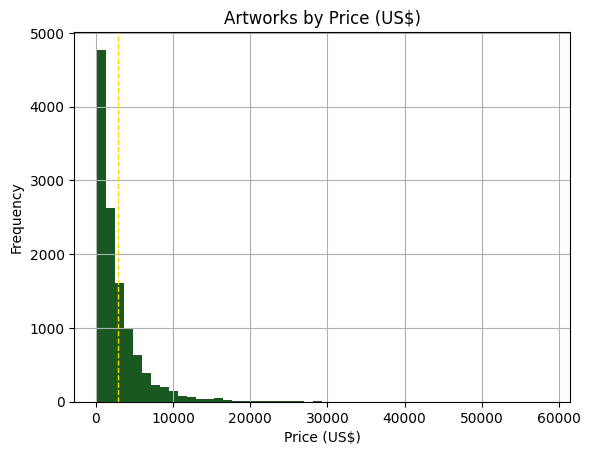

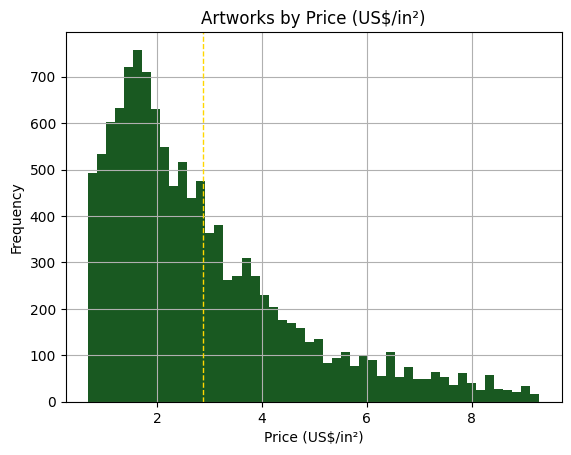

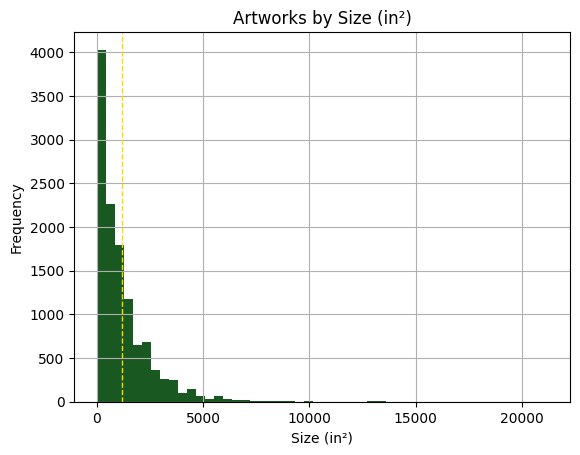

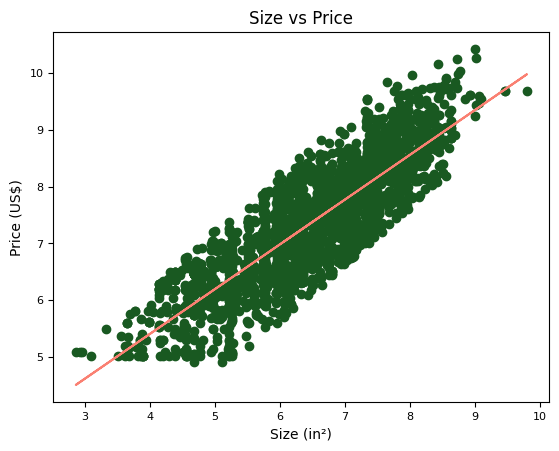

In [98]:
## DESCRIPTIVE STATISTICS OF COLUMNS PRICE, PRICE PER INCH AND SIZE


columns_names = ['Price (US$)', 'Price (US$/in²)', 'Size (in²)']

descritive_df = get_descriptive_stats_of_columns(artworks, columns_names)

## SCATTER PLOT PRICE VS SIZE
plot_scatter(test_dummies, 'Size (in²)', 'Price (US$)', 'Size vs Price', True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


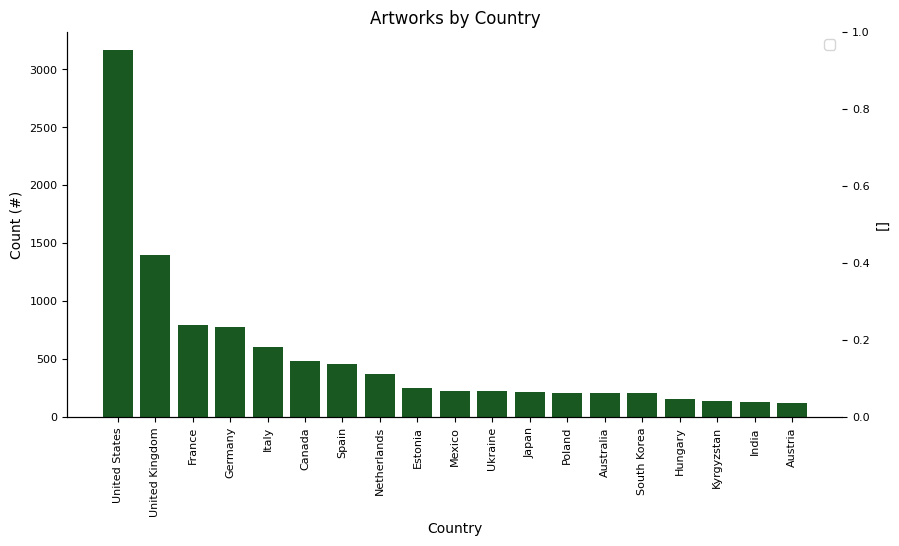

,Mean Price (US$),Median Price (US$),Mean Price (US$/in²),Median Price (US$/in²),Count (#)
Country,,,,,
United States,2884.773000,1500.0,2.872959,2.413127,3163
United Kingdom,2476.196862,1582.5,3.503222,2.892039,1402
France,2279.108040,1500.0,2.629357,2.325492,796
Germany,4529.867609,3070.0,2.832167,2.232329,778
Italy,2579.246689,1895.0,3.346735,2.675585,604
Canada,2640.272917,1805.0,2.392322,1.976374,480
Spain,2619.427948,1600.0,2.915871,2.375995,458
Netherlands,3244.123989,2720.0,2.70312,2.177499,371
Estonia,5136.431452,4070.0,3.984395,3.834694,248


In [42]:
## DESCRIPTIVE STATISTICS OF COUNTRY COLUMN

column_name1 = 'Country'
sort_by1 = 'Count (#)'
min_frequency1 = artworks.shape[0] * 0.01

col_analysis_by_segment = analyse_by_segments(artworks, column_name1, sort_by1, min_frequency1)
plot_segment_chart(col_analysis_by_segment, column_name1, 'Count (#)', [], 'Artworks by ' + column_name1)
col_analysis_by_segment

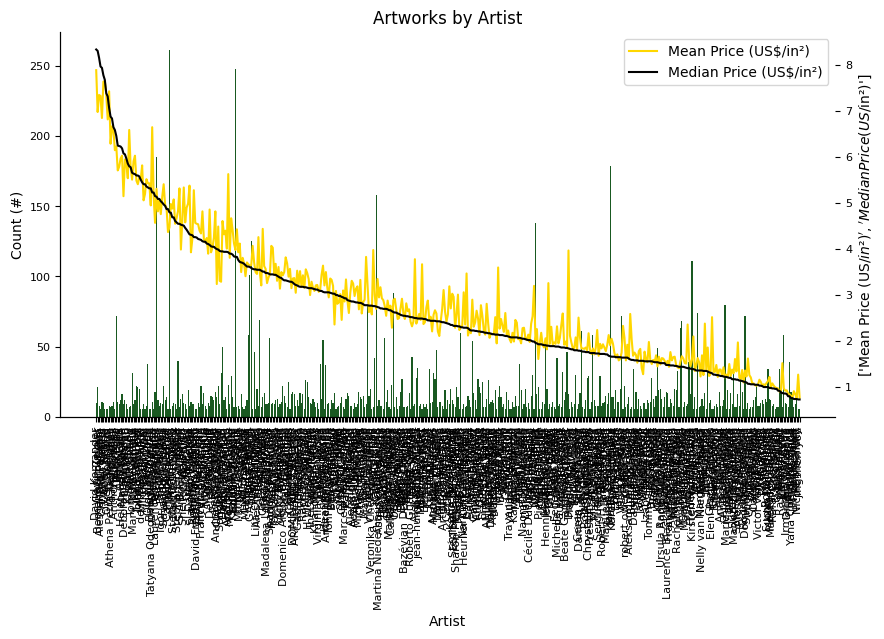

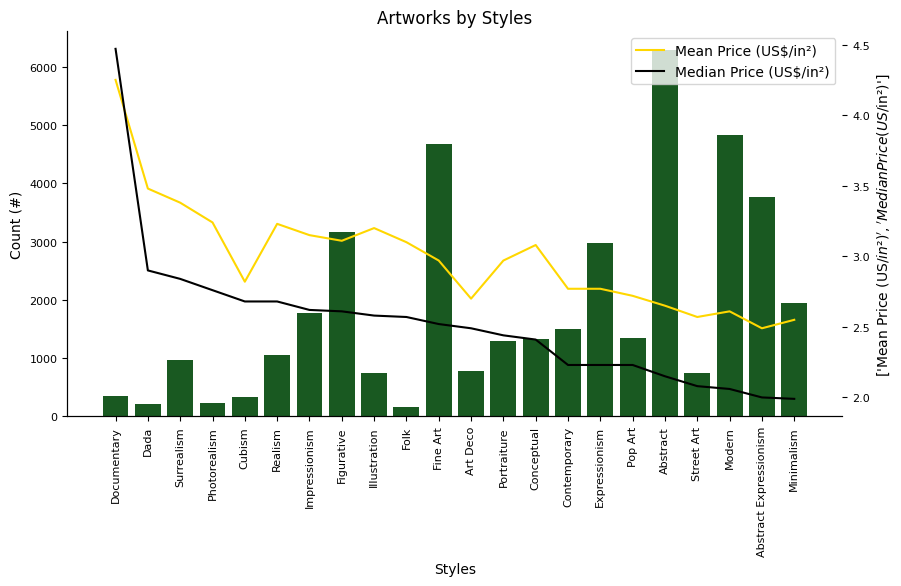

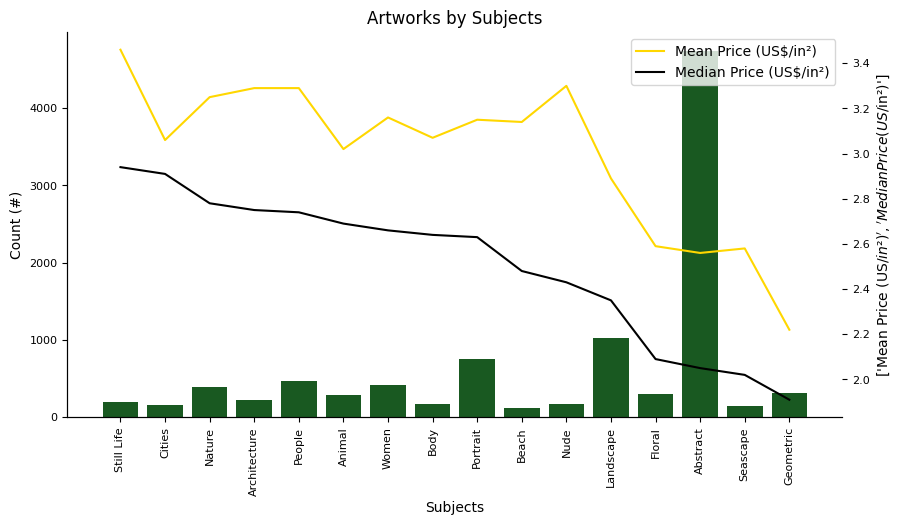

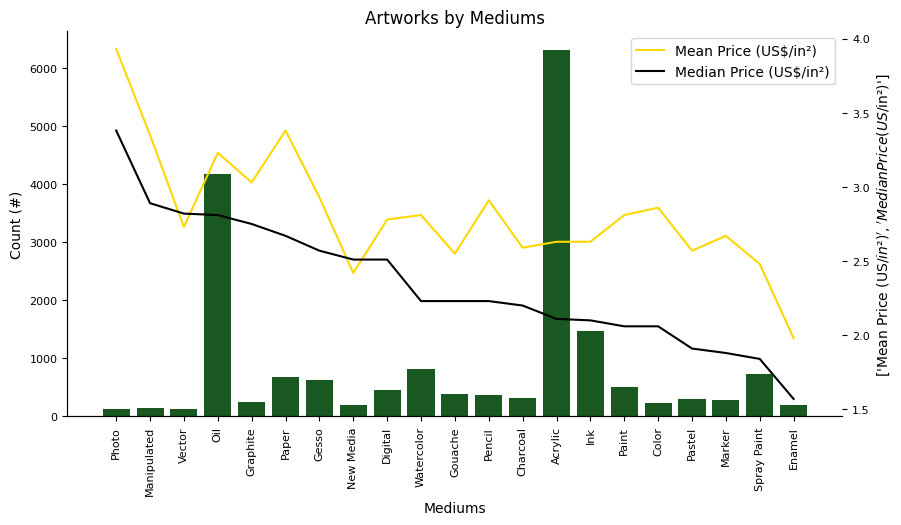

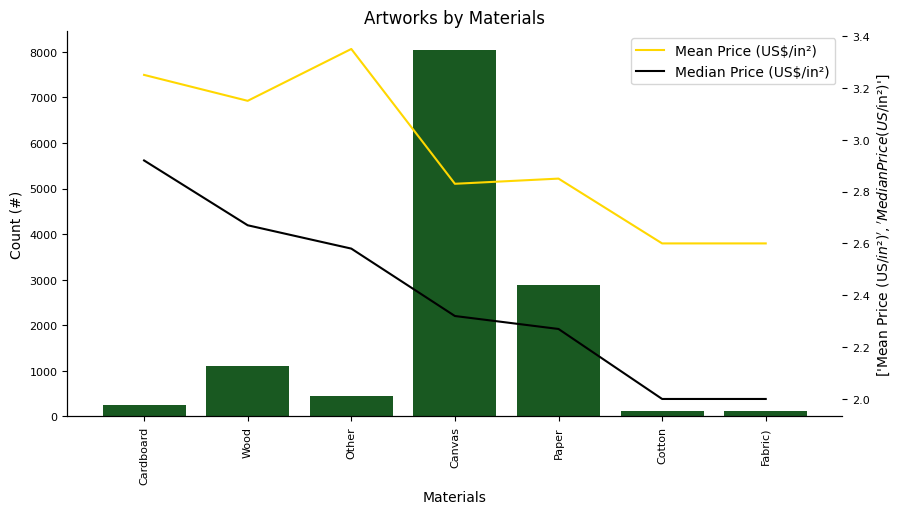

In [43]:
## DESCRIPTIVE STATISTICS OF CATEGORIES (ARTIST, STYLES, SUBJECTS, MEDIUMS, MATERIALS)

categories_columns_list = ['Artist', 'Styles', 'Subjects', 'Mediums', 'Materials']

sort_by = 'Median Price (US$/in²)'

categories_dfs = {}
categories_models_metrics_df = {}
categories_models = {}

for column_name in categories_columns_list:

    if column_name == 'Artist':
        occurrences_threshold = 5
    else:
        occurrences_threshold = artworks.shape[0]/100

    column = artworks[column_name]
    filtered_artworks_data, all_segments_from_category_df, segments_dfs = segment_and_clean_data(artworks, column_name, occurrences_threshold)

    all_segments_from_category_df.drop('Variance (US$/in²)Count (#)', axis=1, inplace=True)
    all_segments_from_category_df.sort_values(by=sort_by, ascending=False, inplace=True)

    plot_segment_chart(all_segments_from_category_df, column_name, 'Count (#)', ['Mean Price (US$/in²)', 'Median Price (US$/in²)'], 'Artworks by ' + column_name)
    categories_dfs[column_name] = all_segments_from_category_df

    # save all_segments_from_category_df as csv
    all_segments_from_category_df.to_csv(f'data_files/descriptive_analysis_{column_name}{quantile}.csv', index=True)

In [44]:
## APPLYING MODELS TO SIZE AND CATEGORIES' DUMMIES

artworks_for_models = artworks[['Artist', 'Styles', 'Subjects', 'Mediums', 'Materials', 'Size (in²)', 'Price (US$)', 'Price (US$/in²)']]

train_data, test_data = train_test_split(artworks_for_models, test_size=0.2, random_state=42)


train_dummies = get_dummies_for_all_segments(train_data, categories_columns_list)
test_dummies = get_dummies_for_all_segments(test_data, categories_columns_list)

# Deal with differences in columns between train and test
missing_cols = set(train_dummies.columns) - set(test_dummies.columns)
for missing_col in missing_cols:
    test_dummies[missing_col] = False
# Ensure the order of column in the test set is in the same order than in train set
test_dummies = test_dummies[train_dummies.columns]

# eliminate duplicate columns
train_dummies = train_dummies.loc[:,~train_dummies.columns.duplicated()]
test_dummies = test_dummies.loc[:,~test_dummies.columns.duplicated()]

x_train = train_dummies.drop(columns=['Price (US$)'])
y_train = train_dummies['Price (US$)']

x_test = test_dummies.drop(columns=['Price (US$)'])
y_test = test_data['Price (US$)']


models_metrics_df, models = get_all_models(x_train, x_test, y_train, y_test)
# # save models_metrics_df as csv
models_metrics_df.to_csv(f'./data_files/models_metrics_df{quantile}.csv', index=True)

models_metrics_df

,Linear regression,Decision tree,Random forest,Gradient boosting
R² Score,0.653133,0.4864,0.681509,0.67381
Adjusted R² Score,0.572964,0.367694,0.607897,0.598419
Pearson Correl Predicted-Actual,0.810237,0.737162,0.826371,0.820981
Mean Absolute Error,1070.683016,1157.324047,930.109658,1049.568845
Median Absolute Error,586.487047,412.5,400.220833,567.203371
Mean Squared Error,3547292.853703,5252422.289871,3257106.341003,3335838.643188


In [77]:
## FEATURE IMPORTANCES

# Select model with lowest MAE
model_name = models_metrics_df.sort_values('Mean Absolute Error', axis=1, ascending=True).columns[0]
model = models[model_name]

feature_importances_df = pd.DataFrame(model.feature_importances_,
                                      index = x_test.columns,
                                        columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)

In [78]:
## GET CATEGORY-CLUSTERED FEATURE IMPORTANCES

# {Category: Segment} dictionay
category_segments_dict = {}
for column_name in categories_columns_list:
    categories = categories_dfs[column_name].index.tolist()
    category_segments_dict[column_name] = categories

# Invert dictionary: {Segment: Category}
segment_categories_dict = {}
segment_categories_dict['Size (in²)'] = 'Size (in²)'
for category, segments in category_segments_dict.items():
    for segment in segments:
        segment_categories_dict[segment] = category

feature_importances_df['Category'] = feature_importances_df.index.map(segment_categories_dict)

feature_importances_df

clustered_feature_importances_df = feature_importances_df.groupby('Category').sum().sort_values('Feature Importance', ascending=False).head(10)

# save to csv
feature_importances_df.to_csv(f'data_files/model_feature_importances{quantile}.csv')
clustered_feature_importances_df.to_csv(f'data_files/model_clustered_feature_importances{quantile}.csv')
clustered_feature_importances_df

,Feature Importance
Category,
Size (in²),0.668950
Artist,0.141801
Styles,0.106098
Mediums,0.042199
Subjects,0.028689
Materials,0.011803


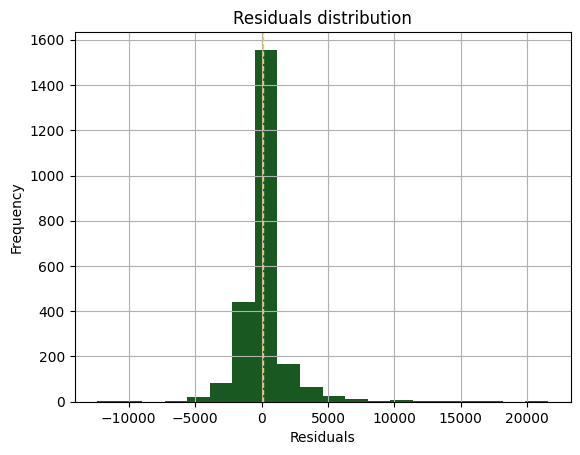

In [54]:
## DISTRIBUTION OF RESIDUALS

# get y_train and y_pred
y_pred = model.predict(x_test)
residuals = y_test - y_pred

plot_histogram(residuals, title='Residuals distribution', x_label='Residuals', y_label='Frequency', bins=20)

In [82]:
## QUANTILE LOSS

def get_quantile_loss(y_true, y_pred, quantile):
    errors = y_true - y_pred
    return np.maximum(quantile * errors, (quantile - 1) * errors)

for quantile in quantiles:
    loss = get_quantile_loss(y_test, y_pred, quantile)
    quantile_loss_value = np.mean(loss)
    print(f"Quantile Loss ({quantile}): {quantile_loss_value:.4f}")

Quantile Loss (0.1): 424.8962
Quantile Loss (0.5): 465.0548
Quantile Loss (0.9): 505.2134


In [108]:
x_test

,Jared Hendler,Kind of Cyan,Mykola Kozlovskyi,Michelle Daisley Moffitt,Yeachin Tsai,Jaime Domínguez,SANTHOSH C H,Eun-Hye Seo,Brad Bealmear,Frederic Belaubre,...,Canvas,Manipulated,Vector,Wood,Cotton,Fabric),Cardboard,Other,Size (in²),Residual
532,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,900.0,1084.266667
4182,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,776.18,-181.530000
12574,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,1103.3,199.020000
482,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,161.88,208.332000
1689,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,1241.1,-158.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,814.0,-1172.310000
7445,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,1410.0,-1502.976667
11687,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,309.29,657.850000
4135,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,185.26,208.700000


In [99]:
## DESCRITIVE ANALYSIS OF ARTWORKS WITH LARGE RESIDUALS

x_test['Residual'] = y_pred - y_test
# get 0.75 quantile of residuals
q75 = x_test['Residual'].quantile(0.75)
# get the artworks with index in large_residual_indices
large_residual_indices = x_test[x_test['Residual'] > q75].index
large_residual_artworks = artworks.loc[large_residual_indices]


columns_names = ['Price (US$)', 'Price (US$/in²)', 'Size (in²)']

descriptive_df = get_descriptive_stats_of_column(large_residual_artworks, columns_names)
descriptive_df.to_csv(f'data_files/descriptive_analysis_{column_name}_large_residuals.csv')

descritive_df

,Price (US$),Price (US$/in²),Size (in²)
max,5.855000e+04,9.285972,2.120664e+04
min,1.350000e+02,0.681250,1.749000e+01
mean,2.851584e+03,2.868842,1.215049e+03
median,1.721000e+03,2.356997,7.745400e+02
stdev,3.428282e+03,1.799354,1.343444e+03
var,1.175312e+07,3.237675,1.804842e+06


In [109]:
## RESIDUALS OF ARTWORKS IN SIZE BINS

# get 0.75 quantile of size
q75_size = np.percentile(artworks['Size (in²)'], 75)
big_size_indices = x_test[x_test['Size (in²)'] >= q75_size]
big_size_dummies = x_test.loc[big_size_indices]

relative_residual_mean = big_size_dummies['Residual'] / big_size_dummies['Price (US$)']
relative_residual_mean.hist(bins=100)

ValueError: Cannot index with multidimensional key

In [ ]:
## ANALYSING QUALITY OF PREDICTION FOR ARTIST

# select artists with most artworks
selected_artists = artworks['Artist'].value_counts().head(10).index
print(selected_artists)

model = models[model_name]

artist_name = 'Frederic Belaubre'
artist_arworks_dummies = test_dummies[test_dummies[artist_name] == 1].sort_values(by='Price (US$)', ascending=False)
artist_arworks_dummies['Price Prediction (US$)'] = model.predict(artist_arworks_dummies.drop(columns=['Price (US$)']))
# Use index to find artworks titles in artworks dataframe
artist_arworks_dummies['Title'] = artworks.loc[artist_arworks_dummies.index]['Title']


# Assuming artist_arworks_dummies is your DataFrame
fig, ax = plt.subplots(figsize=(10, 6))
# Plotting Price Prediction and Price against Artwork Titles
ax.plot(artist_arworks_dummies['Title'], artist_arworks_dummies['Price Prediction (US$)'], label='Price Prediction (US$)')
ax.plot(artist_arworks_dummies['Title'], artist_arworks_dummies['Price (US$)'], label='Price (US$)')
# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
ax.set_xlabel('Artworks')
ax.set_ylabel('Price (US$)')
ax.set_title('Price Prediction vs Price for {}'.format(artist_name))
ax.legend()
plt.tight_layout()  # To ensure labels and titles fit properly
plt.show()

NameError: name 'large_residual_df' is not defined

In [ ]:
## APPLYING MODELS TO SEGMENTS

# multi variate linear regression with price as y and all segments as x
x = dummies_for_segment.drop(['Price (US$)', column_name], axis=1)
# dependent variable
y = dummies_for_segment['Price (US$)']

print('Models for',column_name ,'x','Price (US$)')
get_all_models(x, y)
print()
print(dummies_for_segment.columns)

In [ ]:
# ## COMPARE SEGMENTS:

# artworks_data = get_artworks_df()
# ## COLUMN CHOSEN TO DEFINE SEGMENTS
# column_name = 'Styles'
# column = artworks_data.Styles
# occurrences_threshold = 0

# print('IN EACH LISTED SEGMENT, HOW STRONGLY DOES THE PRICE OF AN ARTWORK DEPEND ON ITS SIZE?')
# print()


# segments_dfs = group_by_segments(artworks_data, column_name, column, occurrences_threshold)


# segments_to_compare = ['Impressionism', 'Photorealism']

# # Variables
# x_column_name = 'Size (in²)'
# y_column_name = 'Price (US$)'

# filtered_artworks_data = artworks_data[artworks_data[column_name].apply(lambda x: any(item in x for item in segments_to_compare))]

# compare_segments(filtered_artworks_data, segments_to_compare, x_column_name, y_column_name)